# Imports

In [11]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import mercantile
from shapely.geometry import box, Point
import ee
import rasterio
from rasterio.transform import xy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [12]:
ee.Initialize()

In [13]:
input_dir  = "../../unsynced-data/embeddings/"
output_dir = "../../unsynced-data/embeddings/outputs/"

# Helper Functions

## Export Embeddings

In [14]:
def export_satellite_embeddings(bbox_coords, filename, resolution=250, year=2021):
    """
    Export Google satellite embeddings for a bounding box.
    bbox_coords: [min_lon, min_lat, max_lon, max_lat]
    """
    # Load collection and create bounding box
    dataset = ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
    bbox = ee.Geometry.Rectangle(bbox_coords)
    
    # Get mosaic without any resampling (to avoid rainbow corruption)
    mosaic = dataset.filterDate(f'{year}-01-01', f'{year+1}-01-01').filterBounds(bbox).mosaic()
    
    # Export task - let GEE handle scaling during export
    task = ee.batch.Export.image.toDrive(
        image=mosaic,
        description=filename,
        folder='GEE_Exports',
        scale=resolution,
        region=bbox,
        maxPixels=1e9,
        crs='EPSG:4326'
    )
    
    task.start()
    print(f"Export task started: {filename}")
    return task



## Raster -> Geodataframe

In [15]:
def raster_to_geodataframe(raster_path):
    """
    Convert a multi-band raster to a GeoDataFrame where:
    - Each row represents a pixel
    - Each column represents a band
    - Geometry column contains the center point of each pixel
    """
    
    with rasterio.open(raster_path) as src:
        # Read all bands
        data = src.read()  # Shape: (bands, height, width)
        transform = src.transform
        crs = src.crs
        
        # Get dimensions
        n_bands, height, width = data.shape
        
        # Create arrays for row and column indices
        rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
        
        # Flatten the arrays
        rows_flat = rows.flatten()
        cols_flat = cols.flatten()
        
        # Convert pixel coordinates to geographic coordinates
        x_coords, y_coords = xy(transform, rows_flat, cols_flat)
        
        # Create Point geometries for each pixel center
        geometries = [Point(x, y) for x, y in zip(x_coords, y_coords)]
        
        # Reshape band data to have pixels as rows and bands as columns
        # data shape: (bands, height, width) -> (height*width, bands)
        pixel_data = data.reshape(n_bands, -1).T
        
        # Create column names for bands
        band_columns = [f'band_{i+1}' for i in range(n_bands)]
        
        # Create DataFrame with band data
        df = pd.DataFrame(pixel_data, columns=band_columns)
        
        # Add coordinate columns (optional, useful for reference)
        df['x'] = x_coords
        df['y'] = y_coords
        df['row'] = rows_flat
        df['col'] = cols_flat
        
        # Create GeoDataFrame
        gdf = gpd.GeoDataFrame(df, geometry=geometries, crs=crs)
        
        return gdf

## Get RGB From Modis

In [16]:
def get_rgb_from_modis_batch(gdf, batch_size=1000):
    """
    Use MODIS for quick RGB-like values (faster, coarser resolution)
    """
    # Use MODIS with pre-computed annual composite
    modis = ee.ImageCollection('MODIS/006/MOD09A1') \
        .filterDate('2022-01-01', '2022-12-31') \
        .select(['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03']) \
        .median() \
        .multiply(0.0001)
    
    # Initialize columns
    gdf['red'] = None
    gdf['green'] = None
    gdf['blue'] = None
    
    # Process in batches (MODIS can handle larger batches)
    for start_idx in range(0, len(gdf), batch_size):
        end_idx = min(start_idx + batch_size, len(gdf))
        batch = gdf.iloc[start_idx:end_idx]
        
        print(f"Processing batch {start_idx//batch_size + 1}/{(len(gdf)-1)//batch_size + 1}")
        
        # Create feature collection for this batch
        features = []
        for idx, row in batch.iterrows():
            point = ee.Geometry.Point([row.geometry.x, row.geometry.y])
            features.append(ee.Feature(point, {"index": idx}))
        
        fc = ee.FeatureCollection(features)
        
        # Sample
        sampled = modis.sampleRegions(
            collection=fc, 
            scale=500,  # 500m resolution (coarser but faster)
            geometries=False
        )
        
        # Get results
        results = sampled.getInfo()
        
        # Map results back
        for feature in results["features"]:
            idx = feature["properties"]["index"]
            gdf.loc[idx, "red"] = feature["properties"].get("sur_refl_b01", None)
            gdf.loc[idx, "green"] = feature["properties"].get("sur_refl_b04", None)
            gdf.loc[idx, "blue"] = feature["properties"].get("sur_refl_b03", None)
    
    return gdf

## Get NDVI from Modis

In [17]:
def get_ndvi_from_modis_batch(gdf, batch_size=1000):
    """
    Get NDVI values from MODIS (fast, coarse resolution)
    """
    # Use MODIS 16-day NDVI product - pre-computed!
    ndvi = ee.ImageCollection('MODIS/006/MOD13Q1') \
        .filterDate('2022-01-01', '2022-12-31') \
        .select('NDVI') \
        .median() \
        .multiply(0.0001)  # Scale to -1 to 1 range
    
    # Initialize column
    gdf['ndvi'] = None
    
    # Process in batches
    for start_idx in range(0, len(gdf), batch_size):
        end_idx = min(start_idx + batch_size, len(gdf))
        batch = gdf.iloc[start_idx:end_idx]
        
        print(f"Processing batch {start_idx//batch_size + 1}/{(len(gdf)-1)//batch_size + 1}")
        
        # Create feature collection for this batch
        features = []
        for idx, row in batch.iterrows():
            point = ee.Geometry.Point([row.geometry.x, row.geometry.y])
            features.append(ee.Feature(point, {"index": idx}))
        
        fc = ee.FeatureCollection(features)
        
        # Sample
        sampled = ndvi.sampleRegions(
            collection=fc, 
            scale=250,  # 250m resolution
            geometries=False
        )
        
        # Get results
        results = sampled.getInfo()
        
        # Map results back
        for feature in results["features"]:
            idx = feature["properties"]["index"]
            gdf.loc[idx, "ndvi"] = feature["properties"].get("NDVI", None)
    
    return gdf

## Plot RGB

In [18]:
def plot_rgb_points_brightened(gdf, figsize=(12, 10), point_size=30, alpha=0.8, brightness=2.0):
    """
    Plot with brightness adjustment
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    x = gdf.geometry.x
    y = gdf.geometry.y
    
    # Boost brightness by multiplying values
    colors = np.column_stack([
        (gdf['red'].fillna(0) * brightness).clip(0, 1),
        (gdf['green'].fillna(0) * brightness).clip(0, 1),
        (gdf['blue'].fillna(0) * brightness).clip(0, 1)
    ])
    
    scatter = ax.scatter(x, y, c=colors, s=point_size, alpha=alpha, 
                        marker='s', edgecolors='none')
    
    ax.set_aspect('equal')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title('Geographic Distribution (Brightened)', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax
# Usage
# fig, ax = plot_rgb_points_brightened(df, brightness=3.5)
# plt.show()

In [19]:
# This method stretches the RGB values to enhance visibility, the brightness method works better for our use case

def plot_rgb_points_stretched(gdf, figsize=(12, 10), point_size=30, alpha=0.8, 
                             lower_percentile=2, upper_percentile=98):
    """
    Plot with percentile stretching for better contrast
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    x = gdf.geometry.x
    y = gdf.geometry.y
    
    # Calculate percentiles for each band
    def stretch_band(band_data):
        valid_data = band_data.dropna()
        if len(valid_data) == 0:
            return band_data.fillna(0)
        p_low = np.percentile(valid_data, lower_percentile)
        p_high = np.percentile(valid_data, upper_percentile)
        stretched = (band_data - p_low) / (p_high - p_low)
        return stretched.clip(0, 1).fillna(0)
    
    colors = np.column_stack([
        stretch_band(gdf['red']),
        stretch_band(gdf['green']),
        stretch_band(gdf['blue'])
    ])
    
    scatter = ax.scatter(x, y, c=colors, s=point_size, alpha=alpha, 
                        marker='s', edgecolors='none')
    
    ax.set_aspect('equal')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title('Geographic Distribution (Contrast Enhanced)', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax
# Usage
# fig, ax = plot_rgb_points_stretched(df)
# plt.show()

# Exporting Embeddings

In [20]:
testing_bboxes_path = input_dir + "/testing_data/testing_bboxes.geojson"
testing_bboxes = gpd.read_file(testing_bboxes_path)
testing_bboxes

,id,name,region,biomes,key_features,major_cities,rural_areas,geometry
0,17,Casablanca-Atlantic Plains,Western Morocco,"Mediterranean scrublands, coastal plains, arga...","Atlantic coast, phosphate mining, agricultural...","Casablanca, El Jadida","Argan oil cooperatives, wheat farming, coastal...","POLYGON ((-8.5 32.5, -6.25 32.5, -6.25 34.75, ..."
1,18,Tripoli-Coastal Desert,Northwestern Libya,"Mediterranean coastal, semi-desert, coastal pl...","Mediterranean coastline, desert transition, oi...","Tripoli, Zawiya","Olive groves, desert-edge farming, Berber comm...","POLYGON ((12.5 32, 14.75 32, 14.75 34.25, 12.5..."
2,19,Khartoum-Blue Nile Confluence,Central Sudan,"Semi-desert, riverine forests, acacia savannas","Blue and White Nile confluence, irrigation sch...","Khartoum, Omdurman, Bahri","Gezira farming scheme, traditional Nile agricu...","POLYGON ((31.5 15, 33.75 15, 33.75 17.25, 31.5..."
3,20,Bamako-Niger Headwaters,Southern Mali,"Sudanian savannas, gallery forests, seasonal w...","Niger River headwaters, gold mining region","Bamako, Koulikoro","Bambara farming communities, traditional gold ...","POLYGON ((-8.5 12, -6.25 12, -6.25 14.25, -8.5..."
4,21,Abuja-Guinea Savanna,Central Nigeria,"Guinea savanna, gallery forests, rocky outcrops","Planned capital city, Jos Plateau proximity, t...","Abuja, Kaduna","Hausa-Fulani communities, traditional farming,...","POLYGON ((7 9, 9.25 9, 9.25 11.25, 7 11.25, 7 9))"
5,22,Bangui-Ubangi River,Southern Central African Republic,"Guinea-Congo forest transition, gallery forest...","Ubangi River, forest-savanna mosaic, diamond r...","Bangui, Boda","Sango communities, traditional fishing, forest...","POLYGON ((18 3.5, 20.25 3.5, 20.25 5.75, 18 5...."
6,23,Dire Dawa-Ethiopian Rift,Eastern Ethiopia,"Acacia savannas, dry montane forests, rift val...","Great Rift Valley, railway junction, khat cult...","Dire Dawa, Harar","Oromo pastoralists, khat farming terraces, tra...","POLYGON ((41.5 9, 43.75 9, 43.75 11.25, 41.5 1..."
7,24,Kisangani-Congo River,Northeastern DRC,"Dense tropical rainforest, Congo River floodpl...","Congo River navigation hub, Boyoma Falls, fore...","Kisangani, Yangambi","Mongo communities, traditional forest manageme...","POLYGON ((25 0, 27.25 0, 27.25 2.25, 25 2.25, ..."
8,25,Mombasa-Coastal Forests,Coastal Kenya,"Coastal forests, coral reefs, mangrove swamps","Indian Ocean coast, major port, coral reef eco...","Mombasa, Kilifi","Mijikenda communities, coconut plantations, tr...","POLYGON ((39 -4.5, 41.25 -4.5, 41.25 -2.25, 39..."
9,26,Lubumbashi-Copperbelt,Southeastern DRC,"Miombo woodlands, gallery forests, mining land...","Copper mining region, miombo-woodland transition","Lubumbashi, Likasi","Luba communities, traditional copper working, ...","POLYGON ((27 -12, 29.25 -12, 29.25 -9.75, 27 -..."


In [ ]:
for i, bbox in enumerate(testing_bboxes.geometry, 1):
    bbox_coords = [bbox.bounds[0], bbox.bounds[1], bbox.bounds[2], bbox.bounds[3]]
    filename = f"testing_satellite_embeddings_{i}"
    export_satellite_embeddings(bbox_coords, filename, resolution=250, year=2021)
    # need to rename first batch of files to testing_...

Exporting testing_satellite_embeddings_1 with coords [-8.5, 32.5, -6.25, 34.75]
Exporting testing_satellite_embeddings_2 with coords [12.5, 32.0, 14.75, 34.25]
Exporting testing_satellite_embeddings_3 with coords [31.5, 15.0, 33.75, 17.25]
Exporting testing_satellite_embeddings_4 with coords [-8.5, 12.0, -6.25, 14.25]
Exporting testing_satellite_embeddings_5 with coords [7.0, 9.0, 9.25, 11.25]
Exporting testing_satellite_embeddings_6 with coords [18.0, 3.5, 20.25, 5.75]
Exporting testing_satellite_embeddings_7 with coords [41.5, 9.0, 43.75, 11.25]
Exporting testing_satellite_embeddings_8 with coords [25.0, 0.0, 27.25, 2.25]
Exporting testing_satellite_embeddings_9 with coords [39.0, -4.5, 41.25, -2.25]
Exporting testing_satellite_embeddings_10 with coords [27.0, -12.0, 29.25, -9.75]
Exporting testing_satellite_embeddings_11 with coords [16.5, -23.0, 18.75, -20.75]
Exporting testing_satellite_embeddings_12 with coords [25.5, -29.5, 27.75, -27.25]
Exporting testing_satellite_embeddings_1

In [26]:
training_bboxes_path = input_dir + "/training_data/training_bboxes.geojson"
training_bboxes = gpd.read_file(training_bboxes_path)
training_bboxes

,id,name,region,biomes,key_features,major_cities,rural_areas,geometry
0,1,Dakar-Sahel Transition,Senegal coast to interior,"Coastal savanna, Sahel grasslands, acacia wood...","Dakar urban area, seasonal wetlands, rural Sah...","Dakar, Thiès","Traditional Sahel pastoralism, millet farming","POLYGON ((-17.5 14, -15.25 14, -15.25 16.25, -..."
1,2,Algiers-Atlas Mountains,Northern Algeria,"Mediterranean forests, montane scrublands, coa...","Atlas Mountains, Mediterranean coast, urban-ru...","Algiers, Blida","Mountain Berber villages, olive groves, wheat ...","POLYGON ((2 36, 4.25 36, 4.25 38.25, 2 38.25, ..."
2,3,Cairo-Nile Delta,Northern Egypt,"Nile riparian forests, desert margins, agricul...","Nile Delta agriculture, desert transition, anc...","Cairo, Giza, Alexandria suburbs","Nile Delta farming communities, traditional fe...","POLYGON ((30.5 30, 32.75 30, 32.75 32.25, 30.5..."
3,4,Freetown-Upper Guinea Forests,Sierra Leone coast to interior,"Coastal rainforest, montane forests, mangroves","Upper Guinea forest biodiversity hotspot, coas...","Freetown, Bo","Forest-dwelling communities, traditional fores...","POLYGON ((-13.5 8, -11.25 8, -11.25 10.25, -13..."
4,5,Lagos-Niger Delta Forests,Southern Nigeria,"Coastal rainforest, mangrove swamps, oil palm ...","Niger Delta wetlands, major urban center, fore...","Lagos, Port Harcourt area","Fishing communities, traditional forest villag...","POLYGON ((3 6, 5.25 6, 5.25 8.25, 3 8.25, 3 6))"
5,6,Addis Ababa-Ethiopian Highlands,Central Ethiopia,"Montane forests, afroalpine grasslands, highla...","High elevation capital, endemic species, tradi...","Addis Ababa, Debre Zeit","Highland farming communities, traditional ense...","POLYGON ((38.5 8.5, 40.75 8.5, 40.75 10.75, 38..."
6,7,Kinshasa-Congo Basin,Western DRC,"Dense tropical rainforest, Congo River floodpl...","Congo River, world's second largest rainforest...","Kinshasa, Brazzaville area","Forest-dependent communities, traditional fish...","POLYGON ((15 -5, 17.25 -5, 17.25 -2.75, 15 -2...."
7,8,Nairobi-East African Savannas,Central Kenya,"Acacia savannas, highland forests, grasslands","Rift Valley, major East African hub, wildlife ...","Nairobi, Nakuru","Maasai pastoralists, smallholder farming, wild...","POLYGON ((36.5 -1.5, 38.75 -1.5, 38.75 0.75, 3..."
8,9,Luanda-Miombo Transition,Northern Angola,"Coastal plains, miombo woodlands, gallery forests","Atlantic coast, woodland-savanna mosaic, oil r...","Luanda, Malanje","Miombo woodland communities, traditional agric...","POLYGON ((13 -9.5, 15.25 -9.5, 15.25 -7.25, 13..."
9,10,Gaborone-Kalahari Edge,Eastern Botswana,"Semi-arid savannas, acacia woodlands, grasslands","Kalahari margin, major regional center, cattle...","Gaborone, Francistown","Cattle posts, traditional villages, semi-nomad...","POLYGON ((25.5 -25, 27.75 -25, 27.75 -22.75, 2..."


In [32]:
for i, bbox in enumerate(training_bboxes.geometry, 1):
    bbox_coords = [bbox.bounds[0], bbox.bounds[1], bbox.bounds[2], bbox.bounds[3]]
    filename = f"training_satellite_embeddings_{i}"
    export_satellite_embeddings(bbox_coords, filename, resolution=250, year=2021)

Export task started: training_satellite_embeddings_1
Export task started: training_satellite_embeddings_2
Export task started: training_satellite_embeddings_3
Export task started: training_satellite_embeddings_4
Export task started: training_satellite_embeddings_5
Export task started: training_satellite_embeddings_6
Export task started: training_satellite_embeddings_7
Export task started: training_satellite_embeddings_8
Export task started: training_satellite_embeddings_9
Export task started: training_satellite_embeddings_10
Export task started: training_satellite_embeddings_11
Export task started: training_satellite_embeddings_12
Export task started: training_satellite_embeddings_13
Export task started: training_satellite_embeddings_14
Export task started: training_satellite_embeddings_15
Export task started: training_satellite_embeddings_16


# OLD STUFF

In [15]:
test_bbox = [-1.32, 11.05, 1.7, 5.15 ]
file_name = 'satellite_embeddings_test_large'
export_task = export_satellite_embeddings(test_bbox, file_name, resolution=250, year=2021)

Export task started: satellite_embeddings_test_large


In [20]:
raster_path = "../../unsynced-data/embeddings/satellite_embeddings_test.tif"
test_gdf = raster_to_geodataframe(raster_path)


 1345, 2629 dimensions

In [26]:
togo_ghana = raster_to_geodataframe("../../unsynced-data/embeddings/togo_ghana_250m_2021.tif")
print ("tg done")
# test_large = raster_to_geodataframe("../../unsynced-data/embeddings/satellite_embeddings_test_large.tif")

tg done


In [27]:
togo_ghana.describe()

,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,...,band_59,band_60,band_61,band_62,band_63,band_64,x,y,row,col
count,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,...,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.536005e+06,3.536005e+06,3.536005e+06,3.536005e+06
mean,4.357654e-02,2.713115e-03,1.606786e-01,-7.032647e-03,-8.924187e-02,-1.628070e-02,-1.979312e-02,9.402283e-02,-8.789194e-02,-4.667813e-02,...,-1.390718e-01,-2.423444e-02,-1.498740e-01,5.722519e-02,7.651004e-02,1.854401e-01,1.897691e-01,8.101681e+00,1.314000e+03,6.720000e+02
std,4.518906e-02,5.544261e-02,8.167825e-02,4.116803e-02,6.646628e-02,4.732807e-02,6.466207e-02,3.892105e-02,4.405196e-02,6.510196e-02,...,8.023520e-02,1.107409e-01,7.959820e-02,8.017386e-02,4.069472e-02,4.086346e-02,8.719677e-01,1.704389e+00,7.589270e+02,3.882680e+02
min,-1.860823e-01,-2.141330e-01,-1.727951e-01,-2.441522e-01,-3.188927e-01,-2.599000e-01,-2.519646e-01,-1.663360e-01,-4.549635e-01,-2.364629e-01,...,-3.647213e-01,-2.928720e-01,-3.839139e-01,-2.599000e-01,-1.793772e-01,-1.476970e-01,-1.319401e+00,5.150715e+00,0.000000e+00,0.000000e+00
25%,1.039600e-02,-3.254133e-02,1.190927e-01,-2.977316e-02,-1.417301e-01,-4.822760e-02,-6.299116e-02,7.111111e-02,-1.137409e-01,-8.421376e-02,...,-1.998616e-01,-1.085121e-01,-1.998616e-01,1.777778e-02,5.536332e-02,1.663360e-01,-5.648157e-01,6.626198e+00,6.570000e+02,3.360000e+02
50%,4.158401e-02,-3.014225e-03,1.727951e-01,-4.982699e-03,-9.842368e-02,-1.384083e-02,-2.977316e-02,9.356401e-02,-8.882737e-02,-6.299116e-02,...,-1.600000e-01,-5.173395e-02,-1.537870e-01,7.535563e-02,7.535563e-02,1.929104e-01,1.897691e-01,8.101681e+00,1.314000e+03,6.720000e+02
75%,7.535563e-02,3.543253e-02,2.141330e-01,1.993080e-02,-4.484429e-02,1.993080e-02,1.574779e-02,1.190927e-01,-6.299116e-02,-3.254133e-02,...,-9.842368e-02,3.844675e-02,-1.190927e-01,1.137409e-01,9.842368e-02,2.141330e-01,9.443539e-01,9.577164e+00,1.971000e+03,1.008000e+03
max,2.288966e-01,3.188927e-01,3.839139e-01,1.929104e-01,1.860823e-01,1.727951e-01,2.761399e-01,3.278124e-01,1.137409e-01,3.278124e-01,...,2.441522e-01,4.237755e-01,1.476970e-01,2.761399e-01,3.936947e-01,3.460208e-01,1.698939e+00,1.105265e+01,2.628000e+03,1.344000e+03


In [28]:
test_large.describe()

,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,...,band_59,band_60,band_61,band_62,band_63,band_64,x,y,row,col
count,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,...,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.358890e+06,3.536005e+06,3.536005e+06,3.536005e+06,3.536005e+06
mean,4.357654e-02,2.713115e-03,1.606786e-01,-7.032647e-03,-8.924187e-02,-1.628070e-02,-1.979312e-02,9.402283e-02,-8.789194e-02,-4.667813e-02,...,-1.390718e-01,-2.423444e-02,-1.498740e-01,5.722519e-02,7.651004e-02,1.854401e-01,1.897691e-01,8.101681e+00,1.314000e+03,6.720000e+02
std,4.518906e-02,5.544261e-02,8.167825e-02,4.116803e-02,6.646628e-02,4.732807e-02,6.466207e-02,3.892105e-02,4.405196e-02,6.510196e-02,...,8.023520e-02,1.107409e-01,7.959820e-02,8.017386e-02,4.069472e-02,4.086346e-02,8.719677e-01,1.704389e+00,7.589270e+02,3.882680e+02
min,-1.860823e-01,-2.141330e-01,-1.727951e-01,-2.441522e-01,-3.188927e-01,-2.599000e-01,-2.519646e-01,-1.663360e-01,-4.549635e-01,-2.364629e-01,...,-3.647213e-01,-2.928720e-01,-3.839139e-01,-2.599000e-01,-1.793772e-01,-1.476970e-01,-1.319401e+00,5.150715e+00,0.000000e+00,0.000000e+00
25%,1.039600e-02,-3.254133e-02,1.190927e-01,-2.977316e-02,-1.417301e-01,-4.822760e-02,-6.299116e-02,7.111111e-02,-1.137409e-01,-8.421376e-02,...,-1.998616e-01,-1.085121e-01,-1.998616e-01,1.777778e-02,5.536332e-02,1.663360e-01,-5.648157e-01,6.626198e+00,6.570000e+02,3.360000e+02
50%,4.158401e-02,-3.014225e-03,1.727951e-01,-4.982699e-03,-9.842368e-02,-1.384083e-02,-2.977316e-02,9.356401e-02,-8.882737e-02,-6.299116e-02,...,-1.600000e-01,-5.173395e-02,-1.537870e-01,7.535563e-02,7.535563e-02,1.929104e-01,1.897691e-01,8.101681e+00,1.314000e+03,6.720000e+02
75%,7.535563e-02,3.543253e-02,2.141330e-01,1.993080e-02,-4.484429e-02,1.993080e-02,1.574779e-02,1.190927e-01,-6.299116e-02,-3.254133e-02,...,-9.842368e-02,3.844675e-02,-1.190927e-01,1.137409e-01,9.842368e-02,2.141330e-01,9.443539e-01,9.577164e+00,1.971000e+03,1.008000e+03
max,2.288966e-01,3.188927e-01,3.839139e-01,1.929104e-01,1.860823e-01,1.727951e-01,2.761399e-01,3.278124e-01,1.137409e-01,3.278124e-01,...,2.441522e-01,4.237755e-01,1.476970e-01,2.761399e-01,3.936947e-01,3.460208e-01,1.698939e+00,1.105265e+01,2.628000e+03,1.344000e+03


In [25]:
test_gdf

,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,...,band_60,band_61,band_62,band_63,band_64,x,y,row,col,geometry
0,0.041584,-0.088827,0.130165,-0.024606,-0.172795,-0.084214,-0.022207,-0.019931,0.113741,-0.221453,...,-0.236463,-0.075356,0.003937,-0.013841,0.029773,40.074968,7.264002,0,0,POINT (40.07497 7.264)
1,0.038447,-0.079723,0.130165,-0.032541,-0.166336,-0.071111,-0.019931,-0.022207,0.124567,-0.259900,...,-0.228897,-0.062991,0.003014,-0.010396,0.044844,40.077214,7.264002,0,1,POINT (40.07721 7.264)
2,0.032541,-0.075356,0.141730,-0.001538,-0.166336,-0.059116,-0.008858,-0.024606,0.119093,-0.259900,...,-0.221453,-0.055363,-0.001538,0.004983,0.035433,40.079459,7.264002,0,2,POINT (40.07946 7.264)
3,0.038447,-0.051734,0.124567,-0.024606,-0.186082,-0.084214,0.013841,-0.013841,0.119093,-0.236463,...,-0.228897,-0.075356,-0.029773,-0.017778,0.062991,40.081705,7.264002,0,3,POINT (40.08171 7.264)
4,0.044844,-0.048228,0.113741,-0.015748,-0.172795,-0.079723,0.032541,-0.041584,0.124567,-0.221453,...,-0.244152,-0.084214,-0.024606,-0.017778,0.055363,40.083951,7.264002,0,4,POINT (40.08395 7.264)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5767,0.051734,-0.079723,0.179377,-0.006151,-0.244152,-0.079723,0.022207,-0.035433,0.259900,-0.124567,...,-0.179377,-0.048228,0.024606,-0.062991,0.035433,40.238910,7.100059,73,73,POINT (40.23891 7.10006)
5768,0.059116,-0.103406,0.206936,-0.008858,-0.236463,-0.088827,-0.019931,-0.006151,0.221453,-0.166336,...,-0.192910,-0.017778,0.027128,-0.059116,0.038447,40.241156,7.100059,73,74,POINT (40.24116 7.10006)
5769,0.055363,-0.093564,0.179377,-0.007443,-0.228897,-0.048228,-0.001538,-0.032541,0.199862,-0.179377,...,-0.153787,-0.001538,0.029773,-0.035433,0.017778,40.243402,7.100059,73,75,POINT (40.2434 7.10006)
5770,0.071111,-0.075356,0.153787,-0.012057,-0.228897,-0.051734,0.007443,-0.032541,0.228897,-0.130165,...,-0.166336,-0.004983,0.048228,-0.038447,0.024606,40.245648,7.100059,73,76,POINT (40.24565 7.10006)


# Get other data from Google Earth Engine

## RGB Data

In [51]:
def get_rgb_from_modis_batch(gdf, batch_size=1000):
    """
    Use MODIS for quick RGB-like values (faster, coarser resolution)
    """
    # Use MODIS with pre-computed annual composite
    modis = ee.ImageCollection('MODIS/006/MOD09A1') \
        .filterDate('2022-01-01', '2022-12-31') \
        .select(['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03']) \
        .median() \
        .multiply(0.0001)
    
    # Initialize columns
    gdf['red'] = None
    gdf['green'] = None
    gdf['blue'] = None
    
    # Process in batches (MODIS can handle larger batches)
    for start_idx in range(0, len(gdf), batch_size):
        end_idx = min(start_idx + batch_size, len(gdf))
        batch = gdf.iloc[start_idx:end_idx]
        
        print(f"Processing batch {start_idx//batch_size + 1}/{(len(gdf)-1)//batch_size + 1}")
        
        # Create feature collection for this batch
        features = []
        for idx, row in batch.iterrows():
            point = ee.Geometry.Point([row.geometry.x, row.geometry.y])
            features.append(ee.Feature(point, {"index": idx}))
        
        fc = ee.FeatureCollection(features)
        
        # Sample
        sampled = modis.sampleRegions(
            collection=fc, 
            scale=500,  # 500m resolution (coarser but faster)
            geometries=False
        )
        
        # Get results
        results = sampled.getInfo()
        
        # Map results back
        for feature in results["features"]:
            idx = feature["properties"]["index"]
            gdf.loc[idx, "red"] = feature["properties"].get("sur_refl_b01", None)
            gdf.loc[idx, "green"] = feature["properties"].get("sur_refl_b04", None)
            gdf.loc[idx, "blue"] = feature["properties"].get("sur_refl_b03", None)
    
    return gdf

In [52]:
test_gdf_with_rgb = get_rgb_from_modis_batch(test_gdf, 500)

/opt/homebrew/Caskroom/miniforge/base/envs/geo_new/lib/python3.12/site-packages/ee/deprecation.py:209: DeprecationWarning: 

Attention required for MODIS/006/MOD09A1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD09A1

  warnings.warn(warning, category=DeprecationWarning)


Processing batch 1/12
Processing batch 2/12
Processing batch 3/12
Processing batch 4/12
Processing batch 5/12
Processing batch 6/12
Processing batch 7/12
Processing batch 8/12
Processing batch 9/12
Processing batch 10/12
Processing batch 11/12
Processing batch 12/12


In [53]:
test_gdf_with_rgb

,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,...,band_63,band_64,x,y,row,col,geometry,red,green,blue
0,0.041584,-0.088827,0.130165,-0.024606,-0.172795,-0.084214,-0.022207,-0.019931,0.113741,-0.221453,...,-0.013841,0.029773,40.074968,7.264002,0,0,POINT (40.07497 7.264),0.1193,0.1001,0.0589
1,0.038447,-0.079723,0.130165,-0.032541,-0.166336,-0.071111,-0.019931,-0.022207,0.124567,-0.259900,...,-0.010396,0.044844,40.077214,7.264002,0,1,POINT (40.07721 7.264),0.1193,0.1001,0.0589
2,0.032541,-0.075356,0.141730,-0.001538,-0.166336,-0.059116,-0.008858,-0.024606,0.119093,-0.259900,...,0.004983,0.035433,40.079459,7.264002,0,2,POINT (40.07946 7.264),0.1099,0.0916,0.0535
3,0.038447,-0.051734,0.124567,-0.024606,-0.186082,-0.084214,0.013841,-0.013841,0.119093,-0.236463,...,-0.017778,0.062991,40.081705,7.264002,0,3,POINT (40.08171 7.264),0.1099,0.0916,0.0535
4,0.044844,-0.048228,0.113741,-0.015748,-0.172795,-0.079723,0.032541,-0.041584,0.124567,-0.221453,...,-0.017778,0.055363,40.083951,7.264002,0,4,POINT (40.08395 7.264),0.1168,0.1045,0.0573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5767,0.051734,-0.079723,0.179377,-0.006151,-0.244152,-0.079723,0.022207,-0.035433,0.259900,-0.124567,...,-0.062991,0.035433,40.238910,7.100059,73,73,POINT (40.23891 7.10006),0.0979,0.0857,0.0488
5768,0.059116,-0.103406,0.206936,-0.008858,-0.236463,-0.088827,-0.019931,-0.006151,0.221453,-0.166336,...,-0.059116,0.038447,40.241156,7.100059,73,74,POINT (40.24116 7.10006),0.101,0.0874,0.0558
5769,0.055363,-0.093564,0.179377,-0.007443,-0.228897,-0.048228,-0.001538,-0.032541,0.199862,-0.179377,...,-0.035433,0.017778,40.243402,7.100059,73,75,POINT (40.2434 7.10006),0.101,0.0874,0.0558
5770,0.071111,-0.075356,0.153787,-0.012057,-0.228897,-0.051734,0.007443,-0.032541,0.228897,-0.130165,...,-0.038447,0.024606,40.245648,7.100059,73,76,POINT (40.24565 7.10006),0.1067,0.0897,0.0593


In [80]:
tg_rgb = get_rgb_from_modis_batch(togo_ghana, 5000)
tg_rgb

Processing batch 1/708
Processing batch 2/708
Processing batch 3/708
Processing batch 4/708
Processing batch 5/708
Processing batch 6/708
Processing batch 7/708
Processing batch 8/708
Processing batch 9/708
Processing batch 10/708
Processing batch 11/708
Processing batch 12/708
Processing batch 13/708
Processing batch 14/708
Processing batch 15/708
Processing batch 16/708
Processing batch 17/708
Processing batch 18/708
Processing batch 19/708
Processing batch 20/708
Processing batch 21/708
Processing batch 22/708
Processing batch 23/708
Processing batch 24/708
Processing batch 25/708
Processing batch 26/708
Processing batch 27/708
Processing batch 28/708
Processing batch 29/708
Processing batch 30/708
Processing batch 31/708
Processing batch 32/708
Processing batch 33/708
Processing batch 34/708
Processing batch 35/708
Processing batch 36/708
Processing batch 37/708
Processing batch 38/708
Processing batch 39/708
Processing batch 40/708
Processing batch 41/708
Processing batch 42/708
P

,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,...,band_63,band_64,x,y,row,col,geometry,red,green,blue
0,0.048228,-0.066990,0.236463,0.051734,-0.179377,-0.000554,-0.135886,0.093564,-0.108512,-0.084214,...,0.075356,0.186082,-1.319401,11.052647,0,0,POINT (-1.3194 11.05265),0.1012,0.0828,0.0475
1,0.044844,-0.029773,0.228897,0.066990,-0.147697,0.000984,-0.119093,0.088827,-0.103406,-0.084214,...,0.079723,0.199862,-1.317155,11.052647,0,1,POINT (-1.31715 11.05265),0.1012,0.0828,0.0475
2,0.044844,-0.024606,0.221453,0.048228,-0.166336,-0.012057,-0.108512,0.071111,-0.098424,-0.079723,...,0.079723,0.206936,-1.314909,11.052647,0,2,POINT (-1.31491 11.05265),0.1032,0.0858,0.0483
3,0.041584,-0.035433,0.221453,0.071111,-0.130165,-0.038447,-0.147697,0.103406,-0.124567,-0.103406,...,0.075356,0.221453,-1.312663,11.052647,0,3,POINT (-1.31266 11.05265),0.1032,0.0858,0.0483
4,0.051734,-0.024606,0.228897,0.075356,-0.135886,-0.035433,-0.147697,0.103406,-0.103406,-0.103406,...,0.066990,0.221453,-1.310417,11.052647,0,4,POINT (-1.31042 11.05265),0.1034,0.0835,0.0489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.689956,5.150715,2628,1340,POINT (1.68996 5.15072),0.0534,0.0611,0.0755
3536001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.692201,5.150715,2628,1341,POINT (1.6922 5.15072),0.0534,0.0611,0.0755
3536002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.694447,5.150715,2628,1342,POINT (1.69445 5.15072),0.0547,0.0625,0.0806
3536003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.696693,5.150715,2628,1343,POINT (1.69669 5.15072),0.0547,0.0625,0.0806


In [90]:
# write to output directory
tg_rgb.to_csv(output_dir + "togo_ghana_rgb.csv", index=False)

### Plot RGB

/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_62074/4214512186.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  (gdf['red'].fillna(0) * brightness).clip(0, 1),
/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_62074/4214512186.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  (gdf['green'].fillna(0) * brightness).clip(0, 1),
/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_62074/4214512186.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future versi

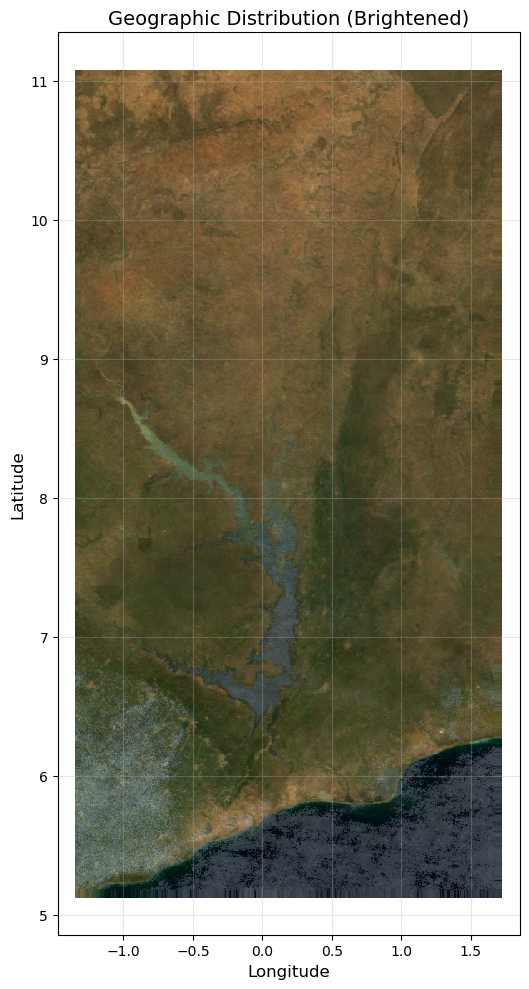

In [ ]:
def plot_rgb_points_brightened(gdf, figsize=(12, 10), point_size=30, alpha=0.8, brightness=2.0):
    """
    Plot with brightness adjustment
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    x = gdf.geometry.x
    y = gdf.geometry.y
    
    # Boost brightness by multiplying values
    colors = np.column_stack([
        (gdf['red'].fillna(0) * brightness).clip(0, 1),
        (gdf['green'].fillna(0) * brightness).clip(0, 1),
        (gdf['blue'].fillna(0) * brightness).clip(0, 1)
    ])
    
    scatter = ax.scatter(x, y, c=colors, s=point_size, alpha=alpha, 
                        marker='s', edgecolors='none')
    
    ax.set_aspect('equal')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title('Geographic Distribution (Brightened)', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax

# Usage
# fig, ax = plot_rgb_points_brightened(tg_rgb, brightness=3.5)
# plt.show()

def plot_rgb_points_stretched(gdf, figsize=(12, 10), point_size=30, alpha=0.8, 
                             lower_percentile=2, upper_percentile=98):
    """
    Plot with percentile stretching for better contrast
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    x = gdf.geometry.x
    y = gdf.geometry.y
    
    # Calculate percentiles for each band
    def stretch_band(band_data):
        valid_data = band_data.dropna()
        if len(valid_data) == 0:
            return band_data.fillna(0)
        p_low = np.percentile(valid_data, lower_percentile)
        p_high = np.percentile(valid_data, upper_percentile)
        stretched = (band_data - p_low) / (p_high - p_low)
        return stretched.clip(0, 1).fillna(0)
    
    colors = np.column_stack([
        stretch_band(gdf['red']),
        stretch_band(gdf['green']),
        stretch_band(gdf['blue'])
    ])
    
    scatter = ax.scatter(x, y, c=colors, s=point_size, alpha=alpha, 
                        marker='s', edgecolors='none')
    
    ax.set_aspect('equal')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title('Geographic Distribution (Contrast Enhanced)', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax
# Usage
fig, ax = plot_rgb_points_stretched(tg_rgb)
plt.show()


/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_62074/2779832027.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return stretched.clip(0, 1).fillna(0)
/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_62074/2779832027.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return stretched.clip(0, 1).fillna(0)
/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_62074/2779832027.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_

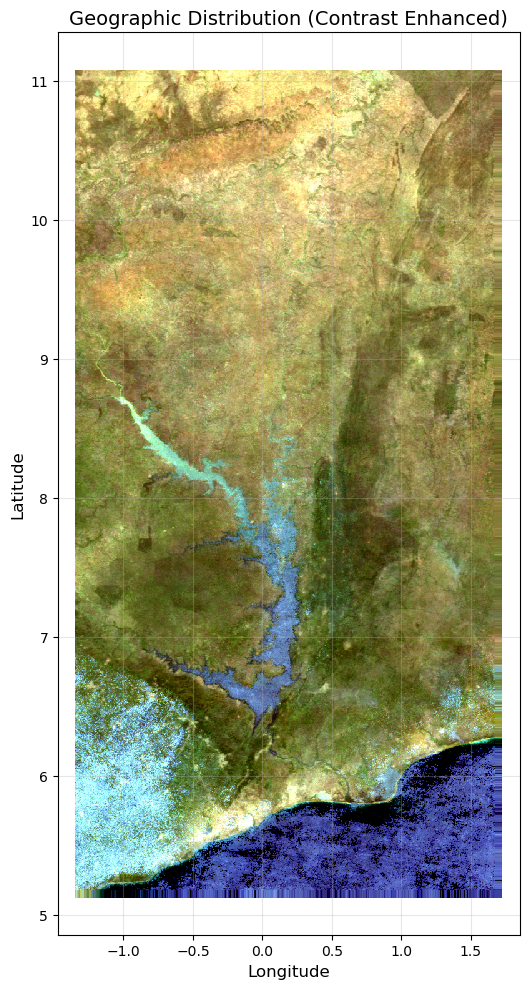

In [ ]:

# Usage
fig, ax = plot_rgb_points_stretched(tg_rgb)
plt.show()

## NDVI Data

In [91]:
def get_ndvi_from_modis_batch(gdf, batch_size=1000):
    """
    Get NDVI values from MODIS (fast, coarse resolution)
    """
    # Use MODIS 16-day NDVI product - pre-computed!
    ndvi = ee.ImageCollection('MODIS/006/MOD13Q1') \
        .filterDate('2022-01-01', '2022-12-31') \
        .select('NDVI') \
        .median() \
        .multiply(0.0001)  # Scale to -1 to 1 range
    
    # Initialize column
    gdf['ndvi'] = None
    
    # Process in batches
    for start_idx in range(0, len(gdf), batch_size):
        end_idx = min(start_idx + batch_size, len(gdf))
        batch = gdf.iloc[start_idx:end_idx]
        
        print(f"Processing batch {start_idx//batch_size + 1}/{(len(gdf)-1)//batch_size + 1}")
        
        # Create feature collection for this batch
        features = []
        for idx, row in batch.iterrows():
            point = ee.Geometry.Point([row.geometry.x, row.geometry.y])
            features.append(ee.Feature(point, {"index": idx}))
        
        fc = ee.FeatureCollection(features)
        
        # Sample
        sampled = ndvi.sampleRegions(
            collection=fc, 
            scale=250,  # 250m resolution
            geometries=False
        )
        
        # Get results
        results = sampled.getInfo()
        
        # Map results back
        for feature in results["features"]:
            idx = feature["properties"]["index"]
            gdf.loc[idx, "ndvi"] = feature["properties"].get("NDVI", None)
    
    return gdf

In [92]:
# Usage
test_gdf_with_rgb_ndvi = get_ndvi_from_modis_batch(test_gdf_with_rgb)

/opt/homebrew/Caskroom/miniforge/base/envs/geo_new/lib/python3.12/site-packages/ee/deprecation.py:209: DeprecationWarning: 

Attention required for MODIS/006/MOD13Q1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1

  warnings.warn(warning, category=DeprecationWarning)


Processing batch 1/6
Processing batch 2/6
Processing batch 3/6
Processing batch 4/6
Processing batch 5/6
Processing batch 6/6


In [105]:
tg_rgb_ndvi = get_ndvi_from_modis_batch(tg_rgb, 5000)

Processing batch 1/708
Processing batch 2/708
Processing batch 3/708
Processing batch 4/708
Processing batch 5/708
Processing batch 6/708
Processing batch 7/708
Processing batch 8/708
Processing batch 9/708
Processing batch 10/708
Processing batch 11/708
Processing batch 12/708
Processing batch 13/708
Processing batch 14/708
Processing batch 15/708
Processing batch 16/708
Processing batch 17/708
Processing batch 18/708
Processing batch 19/708
Processing batch 20/708
Processing batch 21/708
Processing batch 22/708
Processing batch 23/708
Processing batch 24/708
Processing batch 25/708
Processing batch 26/708
Processing batch 27/708
Processing batch 28/708
Processing batch 29/708
Processing batch 30/708
Processing batch 31/708
Processing batch 32/708
Processing batch 33/708
Processing batch 34/708
Processing batch 35/708
Processing batch 36/708
Processing batch 37/708
Processing batch 38/708
Processing batch 39/708
Processing batch 40/708
Processing batch 41/708
Processing batch 42/708
P

In [93]:
test_gdf_with_rgb_ndvi

,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,...,band_64,x,y,row,col,geometry,red,green,blue,ndvi
0,0.041584,-0.088827,0.130165,-0.024606,-0.172795,-0.084214,-0.022207,-0.019931,0.113741,-0.221453,...,0.029773,40.074968,7.264002,0,0,POINT (40.07497 7.264),0.1193,0.1001,0.0589,0.5405
1,0.038447,-0.079723,0.130165,-0.032541,-0.166336,-0.071111,-0.019931,-0.022207,0.124567,-0.259900,...,0.044844,40.077214,7.264002,0,1,POINT (40.07721 7.264),0.1193,0.1001,0.0589,0.482
2,0.032541,-0.075356,0.141730,-0.001538,-0.166336,-0.059116,-0.008858,-0.024606,0.119093,-0.259900,...,0.035433,40.079459,7.264002,0,2,POINT (40.07946 7.264),0.1099,0.0916,0.0535,0.4586
3,0.038447,-0.051734,0.124567,-0.024606,-0.186082,-0.084214,0.013841,-0.013841,0.119093,-0.236463,...,0.062991,40.081705,7.264002,0,3,POINT (40.08171 7.264),0.1099,0.0916,0.0535,0.5084
4,0.044844,-0.048228,0.113741,-0.015748,-0.172795,-0.079723,0.032541,-0.041584,0.124567,-0.221453,...,0.055363,40.083951,7.264002,0,4,POINT (40.08395 7.264),0.1168,0.1045,0.0573,0.4766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5767,0.051734,-0.079723,0.179377,-0.006151,-0.244152,-0.079723,0.022207,-0.035433,0.259900,-0.124567,...,0.035433,40.238910,7.100059,73,73,POINT (40.23891 7.10006),0.0979,0.0857,0.0488,0.3611
5768,0.059116,-0.103406,0.206936,-0.008858,-0.236463,-0.088827,-0.019931,-0.006151,0.221453,-0.166336,...,0.038447,40.241156,7.100059,73,74,POINT (40.24116 7.10006),0.101,0.0874,0.0558,0.3522
5769,0.055363,-0.093564,0.179377,-0.007443,-0.228897,-0.048228,-0.001538,-0.032541,0.199862,-0.179377,...,0.017778,40.243402,7.100059,73,75,POINT (40.2434 7.10006),0.101,0.0874,0.0558,0.3669
5770,0.071111,-0.075356,0.153787,-0.012057,-0.228897,-0.051734,0.007443,-0.032541,0.228897,-0.130165,...,0.024606,40.245648,7.100059,73,76,POINT (40.24565 7.10006),0.1067,0.0897,0.0593,0.3584


## Plot NDVI

/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_62074/2293549597.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ndvi = gdf['ndvi'].fillna(0)


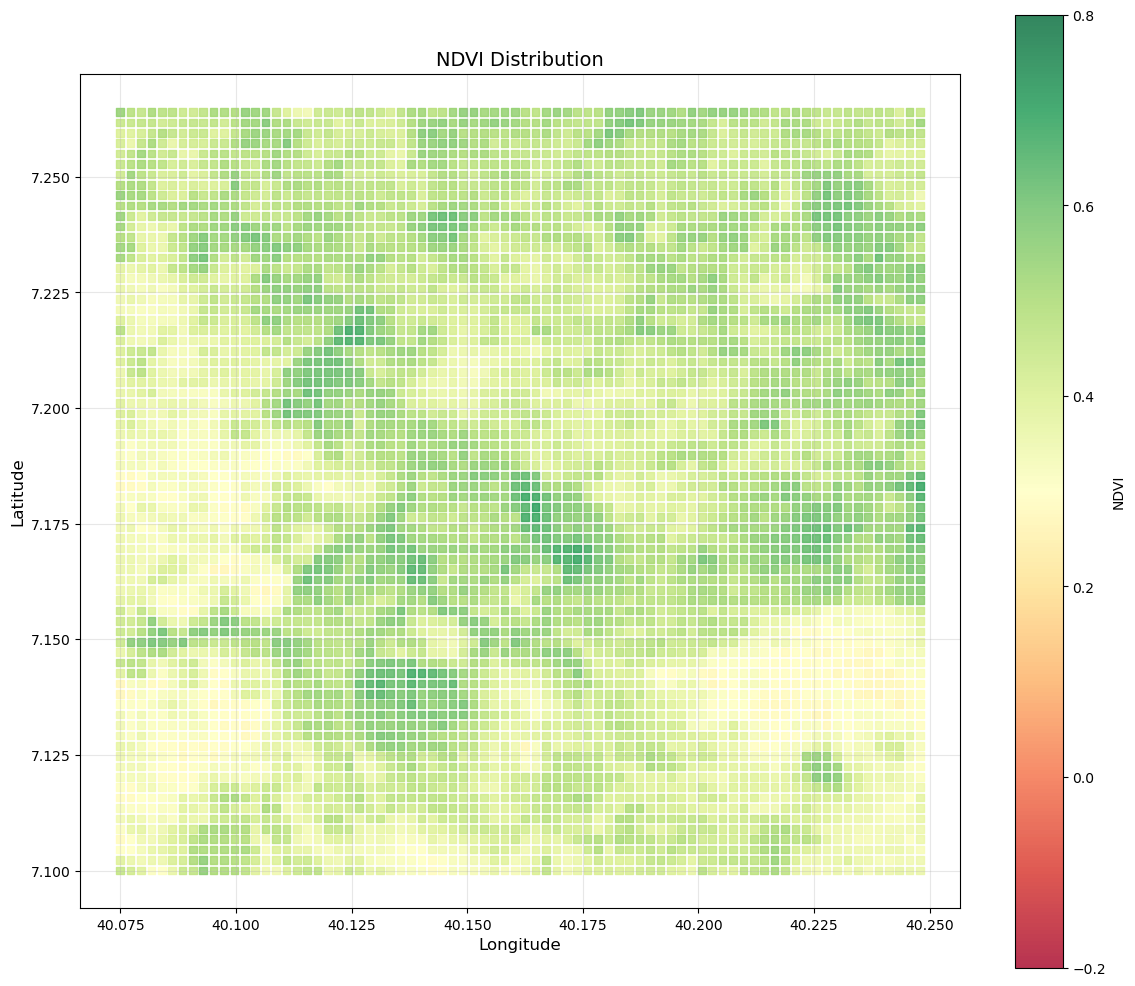

In [102]:
def plot_ndvi_points(gdf, figsize=(12, 10), point_size=30, alpha=0.8, cmap='RdYlGn'):
    """
    Plot points colored by NDVI values
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Extract coordinates
    x = gdf.geometry.x
    y = gdf.geometry.y
    
    # Get NDVI values
    ndvi = gdf['ndvi'].fillna(0)
    
    # Create scatter plot with colorbar
    scatter = ax.scatter(x, y, c=ndvi, s=point_size, alpha=alpha, 
                        marker='s', cmap=cmap, vmin=-0.2, vmax=0.8)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, label='NDVI')
    cbar.ax.tick_params(labelsize=10)
    
    # Set equal aspect ratio
    ax.set_aspect('equal')
    
    # Labels and title
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title('NDVI Distribution', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax

# Usage
fig, ax = plot_ndvi_points(test_gdf_with_rgb_ndvi)
plt.show()

/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_62074/2293549597.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ndvi = gdf['ndvi'].fillna(0)


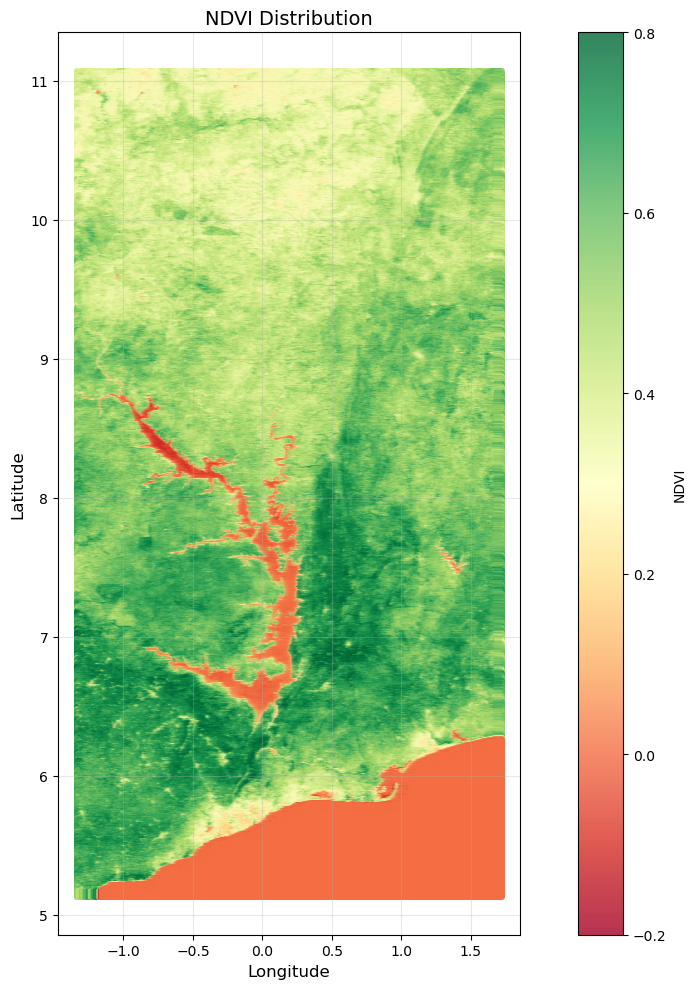

In [106]:
plot_ndvi_points(tg_rgb_ndvi, figsize=(12, 10), point_size=40, alpha=0.8, cmap='RdYlGn')
plt.show()

In [1]:
tg_rgb_ndvi.to_parquet(output_dir + "togo_ghana_rgb_ndvi.parquet", index=False)

NameError: name 'tg_rgb_ndvi' is not defined